In [1]:
# Searching a motif within the mic channel of a .kwd file
# the i-th motiff is in the file pattern_i.wav
# the raw data comes in file experiment.raw.kwd

# Definitions and functions

%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml


# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

#setup the data folder
ss_data_folder = os.path.join(experiment_folder, 'ss_data')

import soundtools as st
import Kwik as oe
from file_tools import experiment as et

def append_rows(table, new_data):
    rows = table.shape[0]
    more_rows = new_data.shape[0]
    table.resize(rows + more_rows, axis=0)
    if table.size == (rows + more_rows):
        table[rows:] = new_data
    else:
        table[rows:,:] = new_data

def unlimited_rows_data(group, table_name, data):
    try:
        table = group.create_dataset(table_name, 
                                     data=data, 
                                     dtype=data.dtype, 
                                     maxshape={None, None})
    except RuntimeError as e:
        if 'Name already exists' in str(e):
            table = group[table_name]
            append_rows(table, data)
        else:
            raise
    return table

def store_motiff(ev_file, rec, bout_starts, motiff_name):
    motiff_group = ev_file.require_group('/event_types/singing/{0}'.format(motiff_name))
    t_table = unlimited_rows_data(motiff_group, 'time_samples', bout_starts)
    r_table = unlimited_rows_data(motiff_group, 'recording', 
                                  data=np.ones_like(bout_starts)*int(rec))

class VizMotiv():
    def __init__(self, all_candidates):
        self.motiff = 0
        self.candidates = all_candidates
        self.is_bout = Checkbox()
        self.fig = plt.figure()
        self.spectr = self.fig.add_subplot(111)
        display(self.is_bout)
    
    def show(self, i):
        self.motiff = i
        motif_start = self.candidates.start[i]
        series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
        f, t, sxx = spectrogram(series[:, 0], s_f, **spectrogram_kwargs)
        self.fig
        plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))
        self.is_bout.value = bool(self.candidates.bout[self.motiff])
        self.is_bout.observe(self.bout_checked, names='value')
        
    def bout_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.candidates.set_value(self.motiff, 'bout', bc['new'])

Computer: passaro


In [2]:
# User Parameters
bird_id = 'z017'
sess = 'day-2016-06-17' #day of recording

# print the list of recs in the file
fn = et.file_names(bird_id, sess, 0)
raw_file_folder = fn['folders']['ss']
sess_file_path = os.path.join(raw_file_folder, fn['files']['ss_raw'])
cand_file_path = et.file_path(fn, 'ss', 'cand')
sess_file = h5py.File(sess_file_path, 'r')
sess_file['recordings'].keys()

[u'0', u'1', u'2']

In [3]:
# prepare files for reading the stream/writing the timestamps
pattern = 1

exp_par = et.get_parameters(bird_id, sess, 0)
search_pars = exp_par['search_motiff']

# get the sound and the pattern
# read a bout from a wave file and prepare the templates
pattern_name = search_pars['motiff_patterns']['motiff_{}'.format(pattern)]
#pattern_name = 'motiff_' + str(pattern) + '.wav'
stim_path = et.file_names(bird_id)['folders']['stim']
pattern_path = os.path.join(stim_path, pattern_name)

pattern_sound = st.WavData2(pattern_path)
s_f = pattern_sound.s_f

# Program parameters:
#filte
filt_lo = search_pars['filt_lo'] #Hz
filt_hi = search_pars['filt_hi'] #Hz
# sonogram 
n_window = search_pars['n_window']
n_overlap = search_pars['n_overlap']
sigma = search_pars['sigma_factor']*s_f
#template match
window_env = search_pars['window_env']

#make the filter for the data file
#The band where we expect most of the energy of zf song to be in
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')

spectrogram_kwargs = {'nperseg': n_window,
                      'noverlap': n_overlap,
                      'window': sg.gaussian(n_window, sigma),
                      'scaling': 'spectrum'}

# Plot the pattern to search
f_cut = 10000
pattern_chunk = st.Chunk(pattern_sound)
pattern_chunk.apply_filter(st.bandpass_filter, s_f)
#plt.plot((pattern_chunk.data))
pattern_envelope = st.envelope(pattern_chunk.data[:,0], window=window_env)
#plt.figure()
#plt.plot(pattern_envelope)
pattern_spectrogram = spectrogram(pattern_chunk.data[:,0], s_f, 
                                  nperseg = n_window, 
                                  noverlap=n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

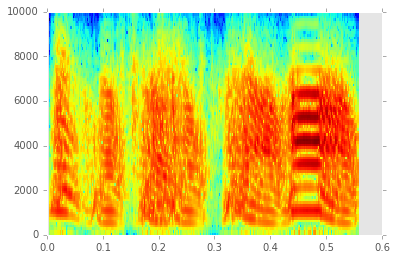

In [10]:
# prepare files for reading the stream/writing the timestamps
rec =2#recording group
fn = et.file_names(bird_id, sess, rec)
cand_grp = '/pattern_{0}/{1}'.format(pattern, rec)

log_file_name = 'search-motiff-aftermath_{0:02}-rec_{1:03}.log'.format(pattern, rec)
log_file_path = os.path.join(fn['folders']['ss'], log_file_name)
# create logger with 'spam_application'
logger = logging.getLogger('searching_motiff_v4')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler(log_file_path)
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

mic_file_path = et.file_path(fn, 'ss', 'mic')
 
# get the sound and the pattern
chan_sound = st.WavData2(mic_file_path)

#read the result of the automatic searching
with pd.HDFStore(cand_file_path) as cnd_file:
    result = cnd_file[cand_grp]

try:
    assert(result.size > 0)
    all_candidates = result[result['bout']==True].sort_values('spectral_diff').reset_index()

    # create logger with 'spam_application'
    logger = logging.getLogger('searching_motiff_aftermath')
    logger.setLevel(logging.DEBUG)
    # create file handler which logs even debug messages
    fh = logging.FileHandler(log_file_path)
    fh.setLevel(logging.DEBUG)
    # create console handler with a higher log level
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    # create formatter and add it to the handlers
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger.addHandler(fh)
    logger.addHandler(ch)

    plt.figure()
    # plot the pattern for reference
    plt.pcolormesh(pattern_spectrogram[1], 
                   pattern_spectrogram[0][pattern_spectrogram[0] < f_cut], 
                   np.log(pattern_spectrogram[2][pattern_spectrogram[0] < f_cut, :]))
except:
    logger.warning('Rec {}: No candidates found'.format(rec))

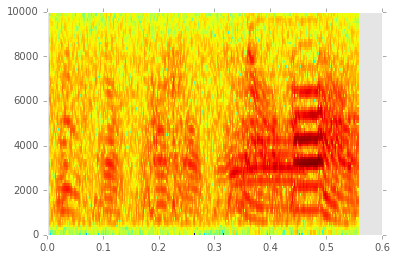

In [11]:
# inspect the result
all_candidates = result.sort_values('spectral_diff').reset_index()
ms = VizMotiv(all_candidates)
widgets.interact(ms.show, i=(0, ms.candidates.index.size-1, 1))

In [45]:
good_ones = range(0, 33) + range(34, 41) + [96]
good_ones

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 96]

In [6]:
all_candidates['bout'] = True
for i_true in good_ones:
    all_candidates.set_value(i_true, 'bout', True)

NameError: name 'good_ones' is not defined

In [40]:
new_pattern_path

'/mnt/cube/earneodo/bci_zf/stim_data/z007/motiff_1a.wav'

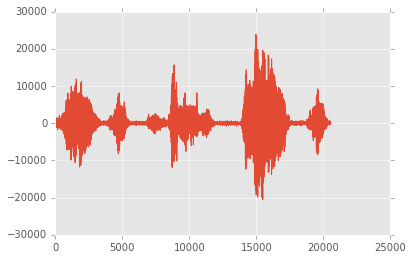

In [39]:
new_pattern_path = os.path.join(stim_path, 'motiff_1a.wav')
new_pattern = (series*3).astype(np.dtype('i2')).flatten()
plt.plot(new_pattern)
wavfile.write(new_pattern_path, 30000, new_pattern)


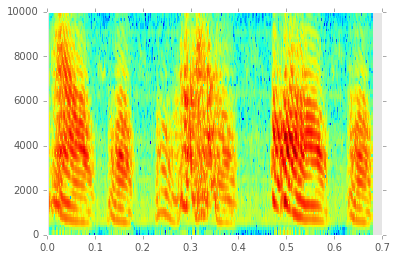

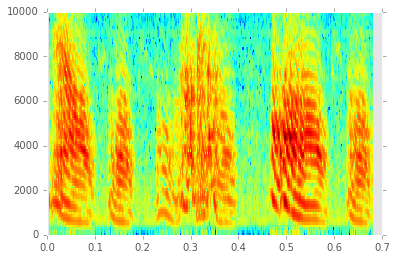

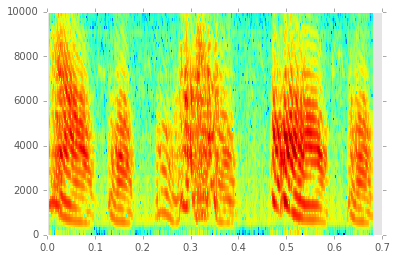

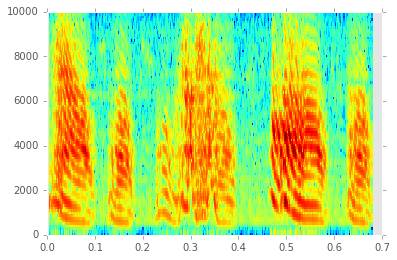

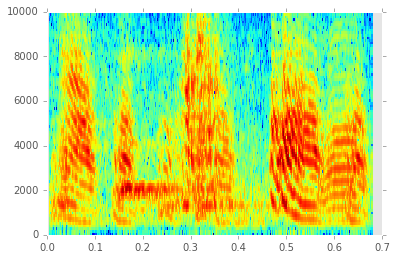

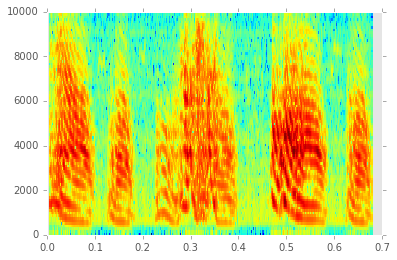

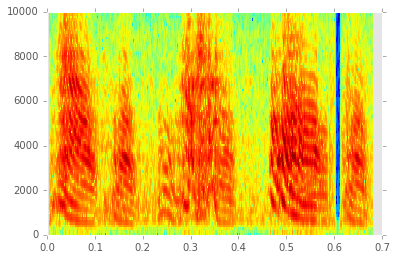

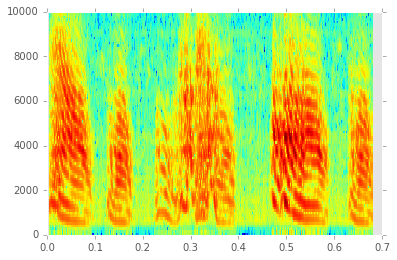

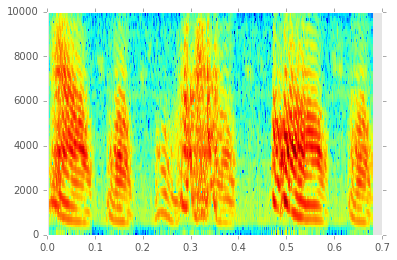

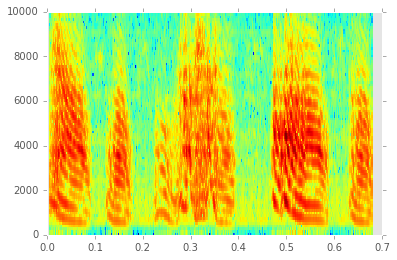

In [115]:
# Double check selection
all_candidates['bout'] = True
store_starts = all_candidates[all_candidates['bout']==True].start.values

for start in store_starts[-10:]:
    motif_start = start
    #print all_candidates[i]
    series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
    # get the histogram
    f, t, sxx = spectrogram(series[:,0], s_f, **spectrogram_kwargs)
    # get the rms
    plt.figure()
    plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))

In [12]:
# Save in the file
store_starts = all_candidates[all_candidates['bout']==True].start.values
log_save_file_name = 'search-motiff_{0:02}-rec_{1:03}.sav.log'.format(pattern, rec)
log_save_file_path = os.path.join(raw_file_folder, log_file_name)
# create file handler which logs even debug messages
fhs = logging.FileHandler(log_file_path)
fhs.setLevel(logging.DEBUG)
fhs.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fhs)

mot_file_path = et.file_path(fn, 'ss', 'sng')
logger.info('Storing {0} motiff starts in {1}'.format(store_starts.size, mot_file_path))
with h5py.File(mot_file_path, 'a') as mot_file:
    store_motiff(mot_file, rec, store_starts, 'motiff_1')

logger.info('Success')

2016-09-21 14:30:15,864 - searching_motiff_aftermath - INFO - Storing 6 motiff starts in /mnt/cube/earneodo/bci_zf/ss_data/z017/day-2016-06-17/experiment.sng.kwe
2016-09-21 14:30:15,864 - searching_motiff_aftermath - INFO - Storing 6 motiff starts in /mnt/cube/earneodo/bci_zf/ss_data/z017/day-2016-06-17/experiment.sng.kwe
2016-09-21 14:30:15,864 - searching_motiff_aftermath - INFO - Storing 6 motiff starts in /mnt/cube/earneodo/bci_zf/ss_data/z017/day-2016-06-17/experiment.sng.kwe
2016-09-21 14:30:15,876 - searching_motiff_aftermath - INFO - Success
2016-09-21 14:30:15,876 - searching_motiff_aftermath - INFO - Success
2016-09-21 14:30:15,876 - searching_motiff_aftermath - INFO - Success


In [53]:
store_starts = all_candidates[all_candidates['bout']==True].start.values

In [26]:
# fix the offsets if run with searching_motiff-v4 (before bug fix) 
st.fix_offset_issue(result, chan_sound, pattern_chunk)
all_candidates = result[result['bout']==True].sort_values('spectral_diff').reset_index()

In [13]:
bird_id = 'z017'
sess = 'day-2016-07-06'
et.get_one_sess_events(bird_id, sess).size

AttributeError: 'NoneType' object has no attribute 'size'

In [27]:
sess

'day-2016-09-12'